In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

from functools import partial
from jax import lax, vmap, jit
import jax.numpy as jnp
import jax.random as jrandom
from jax.flatten_util import ravel_pytree
import numpyro.distributions as dist
import blackjax
import numpy as np
import pandas as pd
from typing import NamedTuple
from jaxtyping import Array, ArrayLike

key = jrandom.PRNGKey(0)

# Structural Identifiability of a Harmonic Oscillator

In this notebook, we will demonstrate how to use Bayesian techniques to tell whether an inverse problem is well-posed.
We'll use the harmonic oscillator as an example, which is given by:

$$
\begin{equation*}
    m \ddot{x} = k x.
\end{equation*}
$$

$$
\begin{equation*}
    x(0) = x_0, \quad \dot{x}(0) = v_0.
\end{equation*}
$$
<!-- 
$$
\begin{equation*}
    y = x + \text{noise}.
\end{equation*}
$$ -->

where $m$ is the mass, $k$ is the spring constant, $x$ is the position of the oscillating object, and $x_0, v_0$ are the initial position and velocity, respectively.
Our goal is to infer the unknown parameters

$$
\begin{equation*}
    \theta = (m, k).
\end{equation*}
$$

However, there is one big problem. 
This ODE system is not ***structurally identifiable***, meaning that there are infinitely many sets of parameters that can produce the same position/velocity trajectory.
We can see this by looking at the solution to the ODE:

$$
\begin{equation*}
    x(t) = x_0 \cos \left(\sqrt{\frac{k}{m}}t\right) + \frac{v_0}{\sqrt{\frac{k}{m}}} \sin \left(\sqrt{\frac{k}{m}}t\right).
\end{equation*}
$$

Only the ratio $k/m$ shows up in the solution.
And there are infinitely many $m$'s and $k$'s that can produce the same ratio.
If we only observe, say, the position $x$, there is not enough information to uniquely identify $m$ and $k$. 
The inverse problem is *ill-posed*.

Many real-life inverse problems, especially those involving differential equations, are ill-posed.
We need a way to deal with them.

## Ill-posed inverse problem

Let's make our inverse problem more concrete.
Our prior knowledge on the parameters is given by

$$
\begin{equation*}
    m \sim \text{Uniform}(1, 2) \quad \text{and} \quad k \sim \text{Uniform}(0.5, 3).
\end{equation*}
$$

Also, suppose the likelihood of the data is i.i.d. Gaussian, i.e.,

$$
\begin{equation*}
    y_i \sim \text{Normal}(x(t_i), \sigma^2) \quad \text{for} \quad i = 1, \dots, N.
\end{equation*}
$$

where $\sigma$ is the noise standard deviation and $(t_i, y_i)_{i=1}^N$ are observations of position at various times.
We will now do the natural thing
&mdash;
sample the posterior $p(\theta | t_{1:N}, y_{1:N})$ with Markov chain Monte Carlo (MCMC).

First, however, let's define some data structures so we stay organized:

In [2]:
# Containers for storing parameters
class OscillatorState(NamedTuple):
    x: float
    v: float

class OscillatorParams(NamedTuple):
    m: float
    k: float
    init_cond: OscillatorState

class MeasurementParams(NamedTuple):
    sigma: float

class Params(NamedTuple):
    oscillator: OscillatorParams
    measurement: MeasurementParams

Next, we need to deal with parameter scaling. 
MCMC requires the parameters to live in *unconstrained* space $\mathbb{R}^d$.
However, the physical parameters $\theta=(m, k, \sigma) \in \Theta \subset \mathbb{R}^d$ are all strictly positive.
Therefore, we will instead work with the unconstrained parameters $\xi \equiv T(\theta) \in \mathbb{R}^d$, where $T: \Theta \rightarrow \mathbb{R}^d$ is some invertible transformation that we pick.

In particular, we'll pick $T$ so that the unconstrained parameters all have a standard normal prior, i.e., $\xi \sim N(0,I)$.

In [3]:
def normal_to_uniform(x, a, b):
    """Transforms from N(0, 1) to U(a, b)."""
    return dist.Normal().cdf(x)*(b - a) + a

def uniform_to_normal(x, a, b):
    """Transforms from U(a, b) to N(0, 1)."""
    return dist.Normal().icdf((x - a)/(b - a))

def exp_transform(x, shift, scale):
    return jnp.exp(x*scale + shift)

def log_transform(x, shift, scale):
    return (jnp.log(x) - shift)/scale

class ParamsTransformation:
    def __init__(self, m_low, m_high, k_low, k_high, sigma_shift, sigma_scale, init_cond=None):
        self.m_low = m_low
        self.m_high = m_high
        self.k_low = k_low
        self.k_high = k_high
        self.sigma_shift = sigma_shift
        self.sigma_scale = sigma_scale
        self.init_cond = init_cond if not None else OscillatorState(x=None, v=None)
        self.split_xi_fn = None
        params_tmp = Params(
            oscillator=OscillatorParams(m=1.0, k=1.0, init_cond=self.init_cond),
            measurement=MeasurementParams(sigma=1.0)
        )
        xi_tmp = self.backward(params_tmp)  # This is just to set unflatten and split functions
        self._n_params = xi_tmp.shape[0]

    def forward(self, xi: ArrayLike) -> Params:
        """Maps from unconstrained to constrained space."""
        osc_, meas_ = self.split_xi_fn(xi)

        # ODE model parameters
        m = normal_to_uniform(osc_[0], self.m_low, self.m_high)
        k = normal_to_uniform(osc_[1], self.k_low, self.k_high)
        osc = OscillatorParams(m=m, k=k, init_cond=self.init_cond)

        # Measurement model parameters
        sigma = exp_transform(meas_[0], self.sigma_shift, self.sigma_scale)
        meas = MeasurementParams(sigma=sigma)

        return Params(oscillator=osc, measurement=meas)
    
    def backward(self, p: Params) -> Array:
        """Maps from constrained to unconstrained space."""
        # ODE model parameters
        xi_m = uniform_to_normal(p.oscillator.m, self.m_low, self.m_high)
        xi_k = uniform_to_normal(p.oscillator.k, self.k_low, self.k_high)
        xi_osc = jnp.hstack((xi_m, xi_k))
        
        # Measurement model parameters
        xi_sigma = log_transform(p.measurement.sigma, self.sigma_shift, self.sigma_scale)
        xi_meas = jnp.hstack((xi_sigma,))
        
        # Combine
        xi, f = ravel_pytree((xi_osc, xi_meas))
        if self.split_xi_fn is None:
            self.split_xi_fn = f
        
        return xi
    
    @property
    def n_params(self):
        return self._n_params

In [4]:
T = ParamsTransformation(
    m_low=1.0,
    m_high=2.0,
    k_low=0.5,
    k_high=3.0,
    sigma_shift=-1,
    sigma_scale=0.5,
    init_cond=OscillatorState(x=1.0, v=0.0)
)

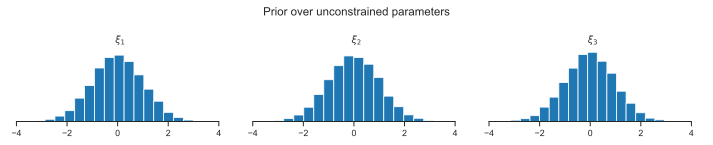

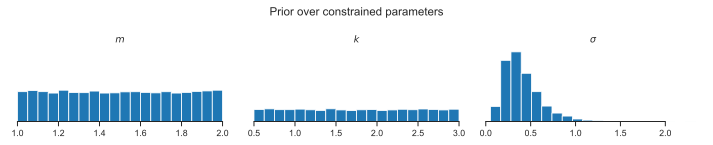

In [5]:
xi_samples = dist.Normal().sample(key, (10000, T.n_params))
theta_samples = vmap(T.forward)(xi_samples)

fig, ax = plt.subplots(1, 3, figsize=(10, 2), sharex=True, sharey=True, tight_layout=True)
fig.suptitle("Prior over unconstrained parameters")
for i, name in enumerate([r"$\xi_1$", r"$\xi_2$", r"$\xi_3$"]):
    ax[i].hist(xi_samples[:, i], bins=20, density=True)
    ax[i].set_title(name)
    ax[i].set_yticks([])
sns.despine(trim=True, left=True)

fig, ax = plt.subplots(1, 3, figsize=(10, 2), sharey=True, tight_layout=True)
fig.suptitle("Prior over constrained parameters")
ax[0].hist(theta_samples.oscillator.m, bins=20, density=True)
ax[1].hist(theta_samples.oscillator.k, bins=20, density=True)
ax[2].hist(theta_samples.measurement.sigma, bins=20, density=True)
for i, name in enumerate([r"$m$", r"$k$", r"$\sigma$"]):
    ax[i].set_title(name)
    ax[i].set_yticks([])
sns.despine(trim=True, left=True)

Perfect. Now, let's code up the model. 
We'll need to sample the prior and predictive distributions, as well as compute the prior and likelihood log probability densities.
We'll put all of this functionality into a class `ProbabilisticDynamicalSystem`.

In [6]:
class ProbabilisticDynamicalSystem:
    """Probabilistic model for a dynamical system."""

    def __init__(self, params_transform, solver):
        """Initialize the model.

        Parameters
        ----------
        params_transform: ParamsTransformation
            An invertible mapping between xi (unconstrained space) and theta (constrained space).
        solver: Callable
            A function that takes a time vector and a set of parameters and returns the state of the system.
        """
        self.params_transform = params_transform
        self.solver = solver
    
    def __call__(self, t, xi, *, key):
        return self.sample_predictive(t, xi, key=key)
    
    def log_prior(self, xi):
        """Prior log density."""
        return jnp.sum(dist.Normal().log_prob(xi))
    
    def log_likelihood(self, xi, obs_times, obs_positions):
        """Likelihood log density."""
        params = self.params_transform.forward(xi)
        positions = self.solver(obs_times, params.oscillator).x
        return jnp.sum(dist.Normal(positions, params.measurement.sigma).log_prob(obs_positions))
    
    def log_posterior(self, xi, obs_times, obs_positions):
        """Posterior log density."""
        return self.log_prior(xi) + self.log_likelihood(xi, obs_times, obs_positions)

    def sample_prior(self, *, key, num_samples=None):
        """Sample xi."""
        return dist.Normal().rsample(key, sample_shape=self._get_sample_shape(num_samples))

    def sample_predictive(self, t, xi, *, key, num_samples=None):
        """Sample from the predictive distribution (given xi) at times t."""
        params = self.params_transform.forward(xi)
        x = self.solver(t, params.oscillator).x
        return dist.Normal(x, params.measurement.sigma).rsample(key)

    def sample_prior_predictive(self, t, *, key, num_samples=None):
        """Sample from the prior predictive distribution at times t."""
        key_xi, key_y = jrandom.split(key)
        if num_samples is None:
            xi = self.sample_prior(key_xi)
            return self.sample_predictive(t, xi, key=key_y)
        else:
            sample_prior_vmapped = vmap(lambda k: self.sample_prior(key=k))
            sample_predictive_vmapped = vmap(lambda t, xi, k: self.sample_predictive(t, xi, key=k), in_axes=(None, 0, 0))
            xi = sample_prior_vmapped(jrandom.split(key_xi, num_samples))
            return sample_predictive_vmapped(t, xi, jrandom.split(key_y, num_samples))
    
    def _get_sample_shape(self, num_samples=None):
        d = self.params_transform.n_params
        return (num_samples, d) if num_samples is not None else (d,)

def harmonic_oscillator(
    t: ArrayLike, 
    params: OscillatorParams
) -> OscillatorState:
    """Analytic solution to the harmonic oscillator ODE system."""
    m = params.m
    k = params.k
    init = params.init_cond
    omega = (k/m)**0.5
    position = init.x*jnp.cos(omega*t) + init.v/omega*jnp.sin(omega*t)
    velocity = -init.x*omega*jnp.sin(omega*t) + init.v*jnp.cos(omega*t)
    return OscillatorState(x=position, v=velocity)

In [7]:
prob_model = ProbabilisticDynamicalSystem(T, harmonic_oscillator)

Just to get familiar with the our newly created `prob_model` object, let's use it to sample position trajectories from the prior:

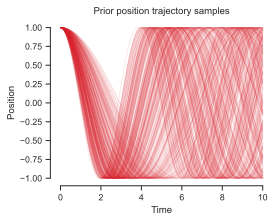

In [8]:
# 1. Sample the prior for xi (this is just a standard Gaussian)
key, subkey = jrandom.split(key)
_xi_prior_samples = prob_model.sample_prior(key=subkey, num_samples=300)

# 2. Transform xi (unconstrained) to theta (constrained)
_theta_prior_samples = vmap(T.forward)(_xi_prior_samples)

# 3. Solve the ODE system for each theta sample
times_plt = jnp.linspace(0, 10, 200)
x_plt = vmap(harmonic_oscillator, in_axes=(None, 0))(times_plt, _theta_prior_samples.oscillator).x

# 4. Plot the samples
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(times_plt, x_plt.T, lw=1, alpha=0.1, color='tab:red')
ax.set_title("Prior position trajectory samples")
ax.set_xlabel("Time")
ax.set_ylabel("Position")
sns.despine(trim=True)

Nice. Let's also use `prob_model` to create some synthetic data:

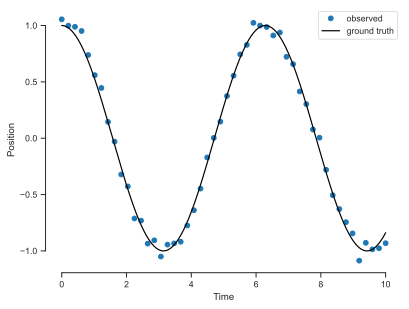

In [9]:
# Create a ground truth
init_cond = OscillatorState(x=1.0, v=0.0)
ground_truth_params = Params(
    oscillator=OscillatorParams(m=1.5, k=1.5, init_cond=init_cond),
    measurement=MeasurementParams(sigma=0.05)
)

# Simulate some observations
obs_times = jnp.linspace(0, 10, 50)
key, subkey = jrandom.split(key)
obs_positions = prob_model.sample_predictive(obs_times, T.backward(ground_truth_params), key=key)

# Plot the observations
fig, ax = plt.subplots()
ax.plot(obs_times, obs_positions, marker='o', lw=0, label="observed")
x_plt = jnp.linspace(obs_times[0], obs_times[-1], 1000)
ax.plot(x_plt, harmonic_oscillator(x_plt, ground_truth_params.oscillator).x, color='k', label="ground truth")
ax.legend()
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Position")
sns.despine(trim=True)

## Detecting nonidentifiability from MCMC samples

We are now ready to solve our inverse problem.
Let's sample from the posterior using the No-U-Turn Sampler (NUTS) algorithm:

In [10]:
# Create wrappers for the density function
log_likelihood_wrapped = partial(prob_model.log_likelihood, obs_times=obs_times, obs_positions=obs_positions)
log_posterior_wrapped = partial(prob_model.log_posterior, obs_times=obs_times, obs_positions=obs_positions)

def inference_loop(key, kernel, initial_state, num_samples):
    @jit
    def one_step(state, key):
        state, info = kernel(key, state)
        return state, state.position

    keys = jrandom.split(key, num_samples)
    _, samples = lax.scan(one_step, initial_state, keys)

    return samples

# Warmup phase, where the NUTS hyperparameters are tuned
init_position = jnp.zeros(3)
warmup = blackjax.window_adaptation(blackjax.nuts, log_posterior_wrapped, is_mass_matrix_diagonal=False)
key, key_warmup, key_sample = jrandom.split(key, 3)
(nuts_state, nuts_parameters), _ = warmup.run(key_warmup, init_position, num_steps=1000)

# Sampling phase
algorithm = blackjax.nuts(log_posterior_wrapped, **nuts_parameters)
key, subkey = jrandom.split(key)
posterior_samples_nuts_xi = inference_loop(key, algorithm.step, nuts_state, 1000)

# Transform the samples to the constrained space
posterior_samples_nuts = vmap(T.forward)(posterior_samples_nuts_xi)

Inspect the trace plots of the samples in unconstrained space:

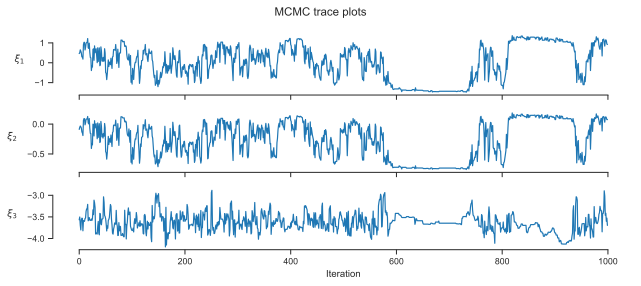

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(9, 4), tight_layout=True, sharex=True)
fig.suptitle("MCMC trace plots")
ax[0].plot(posterior_samples_nuts_xi[:, 0], label="m")
ax[1].plot(posterior_samples_nuts_xi[:, 1], label="k")
ax[2].plot(posterior_samples_nuts_xi[:, 2], label="sigma")
ax[0].set_ylabel(r"$\xi_1$", rotation=0, labelpad=15)
ax[1].set_ylabel(r"$\xi_2$", rotation=0, labelpad=15)
ax[2].set_ylabel(r"$\xi_3$", rotation=0, labelpad=15)
ax[2].set_xlabel("Iteration")
sns.despine(trim=True);

The trace plots for $\xi_1$ and $\xi_2$ (corresponding to $m$ and $k$, respectively) **look like random walks.**
This indicates that the sampler is essentially walking up and down a manifold in $m$-$k$ space.
We can see what this manifold looks like by plotting the samples:

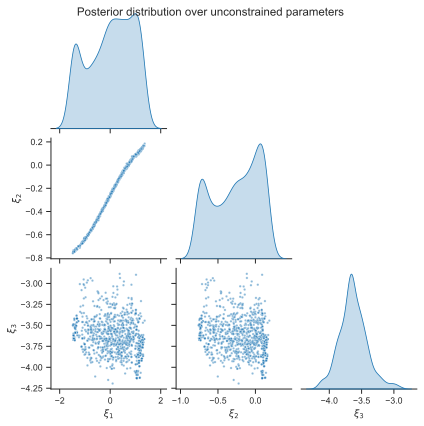

In [12]:
posterior_samples_df = pd.DataFrame(
    np.array([posterior_samples_nuts_xi[:, 0], posterior_samples_nuts_xi[:, 1], posterior_samples_nuts_xi[:, 2]]).T, 
    columns=[r"$\xi_1$", r"$\xi_2$", r"$\xi_3$"]
)


sns.pairplot(
    posterior_samples_df, 
    diag_kind="kde", 
    height=2, aspect=1, markers=".", 
    plot_kws={"alpha": 0.5}, 
    corner=True,
)
plt.suptitle("Posterior distribution over unconstrained parameters");

The band of points in the $\xi_1$-$\xi_2$ scatter plot shows the manifold projected onto the $\xi_1$-$\xi_2$ plane.
Any parameter set that lies on (or close to) this manifold yields practically identical solutions to the dynamical system.
In other words, these plots indicate that **our inverse problem is ill-posed**, since $\xi_1$ and $\xi_2$ cannot be uniquely identified.

## Reparameterization

We can reparameterize the dynamical system so that *is* identifiable. 
In this simple case, we know from the solution that the correct reparameterization is $\omega^2 = \frac{k}{m}$.

But in general, we will not have a closed-form solution.
How then do we know what parameterization we should use? 
Visualizing the solution manifold in constrained, physical space may give us a hint:

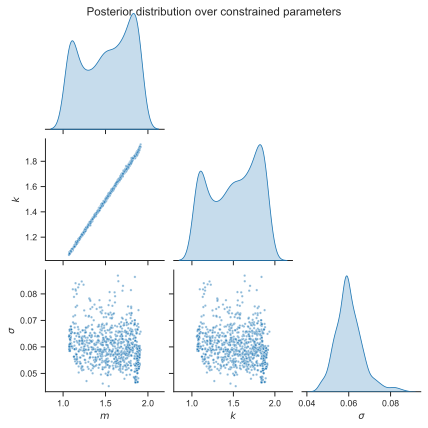

In [13]:
posterior_samples_df = pd.DataFrame(
    np.array([posterior_samples_nuts.oscillator.m, posterior_samples_nuts.oscillator.k, posterior_samples_nuts.measurement.sigma]).T, 
    columns=[r"$m$", r"$k$", r"$\sigma$"]
)

sns.pairplot(
    posterior_samples_df, 
    diag_kind="kde", 
    height=2, aspect=1, markers=".", 
    plot_kws={"alpha": 0.5}, 
    corner=True
)
plt.suptitle("Posterior distribution over constrained parameters");

Aha! The solution manifold projects onto the straight line $m=k$ (as you can see from the $m$-$k$ plot). 
Which means we should reparameterize so that we infer the ratio $\frac{k}{m}$.

Okay, let's implement the reparameterization and solve the new inverse problem:

In [14]:
# Containers for storing parameters
class ReparameterizedOscillatorParams(NamedTuple):
    omega2: float
    init_cond: OscillatorState

class ReparameterizedParams(NamedTuple):
    oscillator: ReparameterizedOscillatorParams
    measurement: MeasurementParams

class ReparameterizedParamsTransformation:
    def __init__(self, omega2_shift, omega2_scale, sigma_shift, sigma_scale, init_cond=None):
        self.omega2_shift = omega2_shift
        self.omega2_scale = omega2_scale
        self.sigma_shift = sigma_shift
        self.sigma_scale = sigma_scale
        self.init_cond = init_cond if not None else OscillatorState(x=None, v=None)
        self.split_xi_fn = None
        params_tmp = Params(
            oscillator=ReparameterizedOscillatorParams(omega2=1.0, init_cond=self.init_cond),
            measurement=MeasurementParams(sigma=1.0)
        )
        xi_tmp = self.backward(params_tmp)  # This is just to set unflatten and split functions
        self._n_params = xi_tmp.shape[0]

    def forward(self, xi: ArrayLike) -> Params:
        """Maps from unconstrained to constrained space."""
        osc_, meas_ = self.split_xi_fn(xi)

        # ODE model parameters
        omega2 = normal_to_uniform(osc_[0], self.omega2_shift, self.omega2_scale)
        osc = ReparameterizedOscillatorParams(omega2=omega2, init_cond=self.init_cond)

        # Measurement model parameters
        sigma = exp_transform(meas_[0], self.sigma_shift, self.sigma_scale)
        meas = MeasurementParams(sigma=sigma)

        return Params(oscillator=osc, measurement=meas)
    
    def backward(self, p: Params) -> Array:
        """Maps from constrained to unconstrained space."""
        # ODE model parameters
        xi_omega2 = uniform_to_normal(p.oscillator.omega2, self.omega2_shift, self.omega2_scale)
        xi_osc = jnp.hstack((xi_omega2,))
        
        # Measurement model parameters
        xi_sigma = log_transform(p.measurement.sigma, self.sigma_shift, self.sigma_scale)
        xi_meas = jnp.hstack((xi_sigma,))
        
        # Combine
        xi, f = ravel_pytree((xi_osc, xi_meas))
        if self.split_xi_fn is None:
            self.split_xi_fn = f
        
        return xi
    
    @property
    def n_params(self):
        return self._n_params

def reparameterized_harmonic_oscillator(
    t: ArrayLike, 
    params: ReparameterizedOscillatorParams
) -> OscillatorState:
    """Analytic solution to the harmonic oscillator ODE system."""
    init = params.init_cond
    omega = params.omega2**0.5
    position = init.x*jnp.cos(omega*t) + init.v/omega*jnp.sin(omega*t)
    velocity = -init.x*omega*jnp.sin(omega*t) + init.v*jnp.cos(omega*t)
    return OscillatorState(x=position, v=velocity)

In [15]:
T_re = ReparameterizedParamsTransformation(
    omega2_shift=0.25,
    omega2_scale=3.0,
    sigma_shift=-1,
    sigma_scale=0.5,
    init_cond=OscillatorState(x=1.0, v=0.0)
)

reparameterized_prob_model = ProbabilisticDynamicalSystem(T_re, reparameterized_harmonic_oscillator)

# Create wrappers for the density function
reparameterized_log_posterior_wrapped = partial(reparameterized_prob_model.log_posterior, obs_times=obs_times, obs_positions=obs_positions)

# Warmup phase, where the NUTS hyperparameters are tuned
init_position_re = jnp.zeros(2)
warmup_re = blackjax.window_adaptation(blackjax.nuts, reparameterized_log_posterior_wrapped, is_mass_matrix_diagonal=False)
key, key_warmup, key_sample = jrandom.split(key, 3)
(nuts_state_re, nuts_parameters_re), _ = warmup_re.run(key_warmup, init_position_re, num_steps=1000)

# Sampling phase
algorithm_re = blackjax.nuts(reparameterized_log_posterior_wrapped, **nuts_parameters_re)
key, subkey = jrandom.split(key)
posterior_samples_nuts_xi_re = inference_loop(key, algorithm_re.step, nuts_state_re, 1000)

# Transform the samples to the constrained space
posterior_samples_nuts_re = vmap(T_re.forward)(posterior_samples_nuts_xi_re)

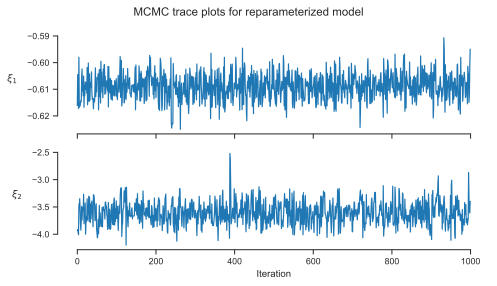

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), tight_layout=True, sharex=True)
fig.suptitle("MCMC trace plots for reparameterized model")
ax[0].plot(posterior_samples_nuts_xi_re[:, 0], label=r"$\omega^2$")
ax[1].plot(posterior_samples_nuts_xi_re[:, 1], label=r"$\sigma$")
ax[0].set_ylabel(r"$\xi_1$", rotation=0, labelpad=15)
ax[1].set_ylabel(r"$\xi_2$", rotation=0, labelpad=15)
ax[1].set_xlabel("Iteration")
sns.despine(trim=True);

These look more like uncorrelated MCMC samples, which is a good sign&mdash;it means the parameters are identifiable.
Let's look at the samples:

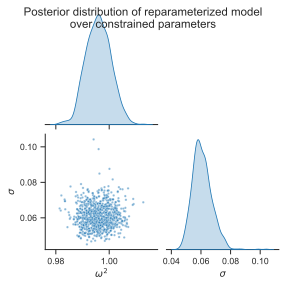

In [17]:
posterior_samples_df_re = pd.DataFrame(
    np.array([posterior_samples_nuts_re.oscillator.omega2, posterior_samples_nuts_re.measurement.sigma]).T, 
    columns=[r"$\omega^2$", r"$\sigma$"]
)

sns.pairplot(
    posterior_samples_df_re, 
    diag_kind="kde", 
    height=2, aspect=1, markers=".", 
    plot_kws={"alpha": 0.5}, 
    corner=True
)
plt.suptitle("Posterior distribution of reparameterized model\nover constrained parameters");

$\omega^2$ is identifiable.